### Statistics, Prediction, and Reproducibility

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# load input images
all_tif_images=glob('./BBBC010_v1_images/*_w1_*.tif')
all_fg_images=glob('./BBBC010_v1_foreground/*.png')
# put input images paths into pandas DataFrame
image_df=pd.DataFrame([{'gfp_path': f} for f in all_tif_images])

image_df.iloc[1,0]

'./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20070424_D17_w1_F4BF2BD5-2D4A-42D8-AA27-FADB35E8D7A5.tif'

In [7]:
# define mapping function
def _get_light_path(in_path):
    w2_path='_w2_'.join(in_path.split('_w1_'))
    glob_str='_'.join(w2_path.split('_')[:-1]+['*.tif'])
    m_files=glob(glob_str)
    if len(m_files)>0:
        return m_files[0]
    else:
        return None
# create new columns with yet another paths
image_df['light_path']=image_df['gfp_path'].map(_get_light_path)
image_df=image_df.dropna()
image_df['base_name']=image_df['gfp_path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])

image_df['base_name'][1]

'1649_1109_0003_Amp5-1_B_20070424_D17_w1_F4BF2BD5-2D4A-42D8-AA27-FADB35E8D7A5'

In [8]:
# Extract data from the image name

# clearly this is not the case
# <plate>_<wellrow>_<wellcolumn>_<wavelength>_<fileid>.tif
# Columns 1-12 are positive controls treated with ampicillin. Columns 13-24 are untreated negative controls.
# we apply a new rule
# 1649_1109_0003_Amp5-1_B_20070424_A01_w1_9E84F49F-1B25-4E7E-8040-D1BB2D7E73EA.tif
# junk_junk_junk_junk_junk_date_RowCol_wavelength_id.tif

image_df['plate_rc']=image_df['base_name'].map(lambda x: x.split('_')[6])
image_df['row']=image_df['plate_rc'].map(lambda x: x[0:1])
image_df['column']=image_df['plate_rc'].map(lambda x: int(x[1:]))
image_df['treated']=image_df['column'].map(lambda x: x<13)
image_df['wavelength']=image_df['base_name'].map(lambda x: x.split('_')[7])

image_df['mask_path']=image_df['plate_rc'].map(lambda x: './BBBC010_v1_foreground/{}_binary.png'.format(x))
print('Loaded',image_df.shape[0],'datasets')
# pd.df.sample - Returns a random sample of items from an axis of object.
image_df.sample(3)

Loaded 97 datasets


,gfp_path,light_path,base_name,plate_rc,row,column,treated,wavelength,mask_path
89,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,1649_1109_0003_Amp5-1_B_20070424_C06_w1_56EDF5...,C06,C,6,True,w1,./BBBC010_v1_foreground/C06_binary.png
30,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,1649_1109_0003_Amp5-1_B_20070424_B11_w1_E3AD5D...,B11,B,11,True,w1,./BBBC010_v1_foreground/B11_binary.png
85,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,1649_1109_0003_Amp5-1_B_20070424_E04_w1_3EA352...,E04,E,4,True,w1,./BBBC010_v1_foreground/E04_binary.png


### Show an example of treated sample

Test Image: (520, 696)


Text(0.5,1,'Segmented')

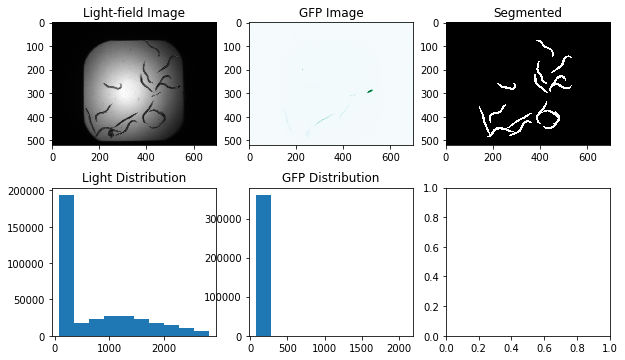

In [9]:
%matplotlib inline
test_image_row=list(image_df.query('treated').sample(1).T.to_dict().values())[0]
test_img=imread(test_image_row['light_path'])
test_gfp=imread(test_image_row['gfp_path'])
test_bg=imread(test_image_row['mask_path'])
print('Test Image:',test_img.shape)

fig, ((ax_light,ax_gfp, ax4),(ax2 ,ax3, _)) = plt.subplots(2,3, figsize = (10,6))
ax_light.imshow(test_img,cmap='gray')
ax_light.set_title('Light-field Image'.format(**test_image_row))

ax_gfp.imshow(np.sqrt(test_gfp),cmap='BuGn')
ax_gfp.set_title('GFP Image'.format(**test_image_row))

ax2.hist(test_img.ravel())
ax2.set_title('Light Distribution')

ax3.hist(test_gfp.ravel())
ax3.set_title('GFP Distribution')

ax4.imshow(test_bg, cmap = 'bone')
ax4.set_title('Segmented')

### Show an example of untreated control

Test Image: (520, 696)


Text(0.5,1,'Segmented')

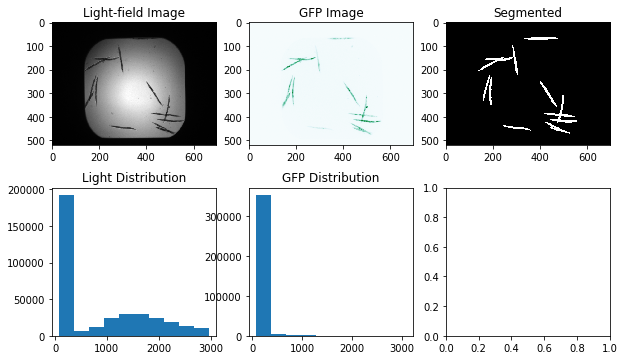

In [10]:
%matplotlib inline
test_image_row=list(image_df.query('treated==False').sample(1).T.to_dict().values())[0]
test_img=imread(test_image_row['light_path'])
test_gfp=imread(test_image_row['gfp_path'])
test_bg=imread(test_image_row['mask_path'])
print('Test Image:',test_img.shape)

fig, ((ax_light,ax_gfp, ax4),(ax2 ,ax3, _)) = plt.subplots(2,3, figsize = (10,6))
ax_light.imshow(test_img,cmap='gray')
ax_light.set_title('Light-field Image'.format(**test_image_row))

ax_gfp.imshow(np.sqrt(test_gfp),cmap='BuGn')
ax_gfp.set_title('GFP Image'.format(**test_image_row))

ax2.hist(test_img.ravel())
ax2.set_title('Light Distribution')

ax3.hist(test_gfp.ravel())
ax3.set_title('GFP Distribution')

ax4.imshow(test_bg, cmap = 'bone')
ax4.set_title('Segmented')

Load the data on individual worms

In [11]:
worm_df=pd.read_csv('./BBBC010_v1_foreground_eachworm.csv')
worm_df.sample(3)

,Unnamed: 0,base_name,plate_rc,worm_id,worm_pixel_area
1145,1145,D09_09_ground_truth,D09,9,1130
393,393,B04_04_ground_truth,B04,4,900
1227,1227,D15_08_ground_truth,D15,8,1034


Summarize the count and area

In [12]:
worm_summary_df=worm_df.groupby('plate_rc').agg({'worm_id':'max', 'worm_pixel_area': 'sum'}).reset_index().rename(columns={'worm_id':'worm_count'})
worm_summary_df.sample(4)

,plate_rc,worm_count,worm_pixel_area
40,B17,12,12230
43,B20,14,12440
73,D02,15,15616
82,D11,15,14491


In [13]:
# The npz was saved directly from a pandas df and so it is a bit uglier (hence the additional ravel), h5 was unfortunately too poorly compressed
with np.load('./BBBC010_v1_foreground_eachworm.npz') as mask_npz:
    mask_df=pd.DataFrame({k:[iv for ik,iv in v.ravel()[0].items()] 
                          for k,v in mask_npz.items() if 'path' not in k})
mask_df.sample(4)

,worm_image,base_name,worm_id,plate_rc,worm_pixel_area
454,"[[False, False, False, False, False, False, Fa...",B08_06_ground_truth,6,B08,1226
1118,"[[False, False, False, False, False, False, Fa...",D07_11_ground_truth,11,D07,1188
1199,"[[False, False, False, False, False, False, Fa...",D13_04_ground_truth,4,D13,1188
1229,"[[False, False, False, False, False, False, Fa...",D15_10_ground_truth,10,D15,1120


# Simple Analysis of Image Intensity and Std

In [14]:
# Rename logocal column
image_df['treated']=image_df['treated'].map(lambda x: 'ampicillin' if x else 'negative control')
image_df.sample(3)

,gfp_path,light_path,base_name,plate_rc,row,column,treated,wavelength,mask_path
80,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,1649_1109_0003_Amp5-1_B_20070424_D06_w1_D3232A...,D06,D,6,ampicillin,w1,./BBBC010_v1_foreground/D06_binary.png
33,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,1649_1109_0003_Amp5-1_B_20070424_D10_w1_8D8C78...,D10,D,10,ampicillin,w1,./BBBC010_v1_foreground/D10_binary.png
36,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,1649_1109_0003_Amp5-1_B_20070424_D13_w1_3791F5...,D13,D,13,negative control,w1,./BBBC010_v1_foreground/D13_binary.png


In [15]:
# Get very basic statistics of individual images
#%%time
image_df['light_mean']=image_df['light_path'].map(lambda x: np.mean(imread(x)))
image_df['gfp_mean']=image_df['gfp_path'].map(lambda x: np.mean(imread(x)))
image_df['light_sd']=image_df['light_path'].map(lambda x: np.std(imread(x)))
image_df['gfp_sd']=image_df['gfp_path'].map(lambda x: np.std(imread(x)))
image_df.sample(3)

# The standard deviation is as high as mean ... wide spread of values

,gfp_path,light_path,base_name,plate_rc,row,column,treated,wavelength,mask_path,light_mean,gfp_mean,light_sd,gfp_sd
2,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,1649_1109_0003_Amp5-1_B_20070424_A19_w1_E1516A...,A19,A,19,negative control,w1,./BBBC010_v1_foreground/A19_binary.png,881.471491,121.819546,908.696167,121.867657
75,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,1649_1109_0003_Amp5-1_B_20070424_B07_w1_3474AF...,B07,B,7,ampicillin,w1,./BBBC010_v1_foreground/B07_binary.png,973.708844,99.836337,970.718398,42.767032
4,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,./BBBC010_v1_images/1649_1109_0003_Amp5-1_B_20...,1649_1109_0003_Amp5-1_B_20070424_B22_w1_81E0BD...,B22,B,22,negative control,w1,./BBBC010_v1_foreground/B22_binary.png,847.113232,117.292377,894.171990,108.670567


# Showing Correlations
Here we can see correlations for the dataset and it is very evident that the GFP signal quite strongly separates living from dead worms

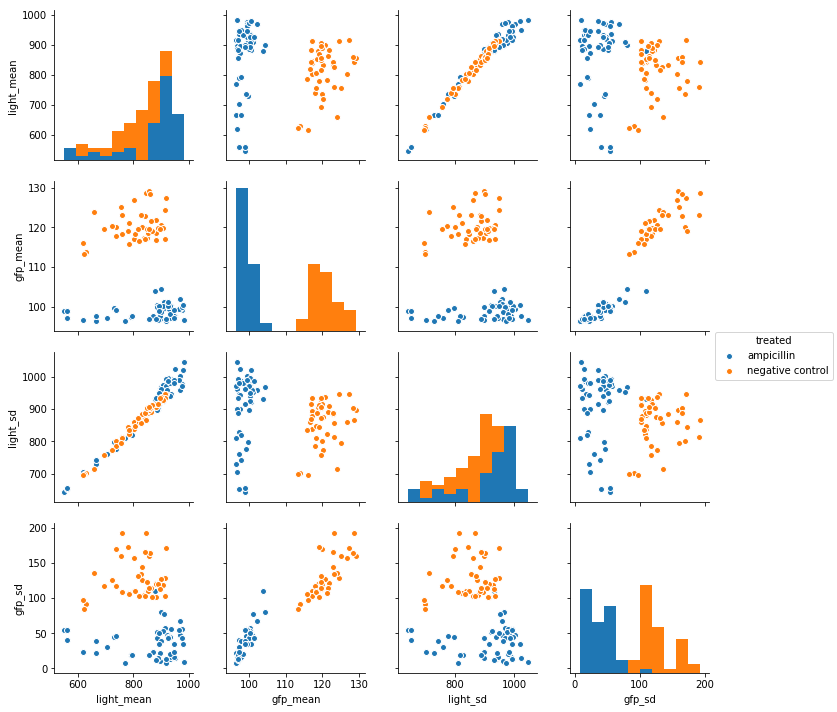

In [16]:
# this function obviously takes only numeric values from supplied data frame and plots their combinations
# the color is given by whether the sampel was treated or not
sns.pairplot(image_df.drop(['column'],1),hue='treated')

# Adding the worm information
Now we can what additional information we get from segmenting the worms out

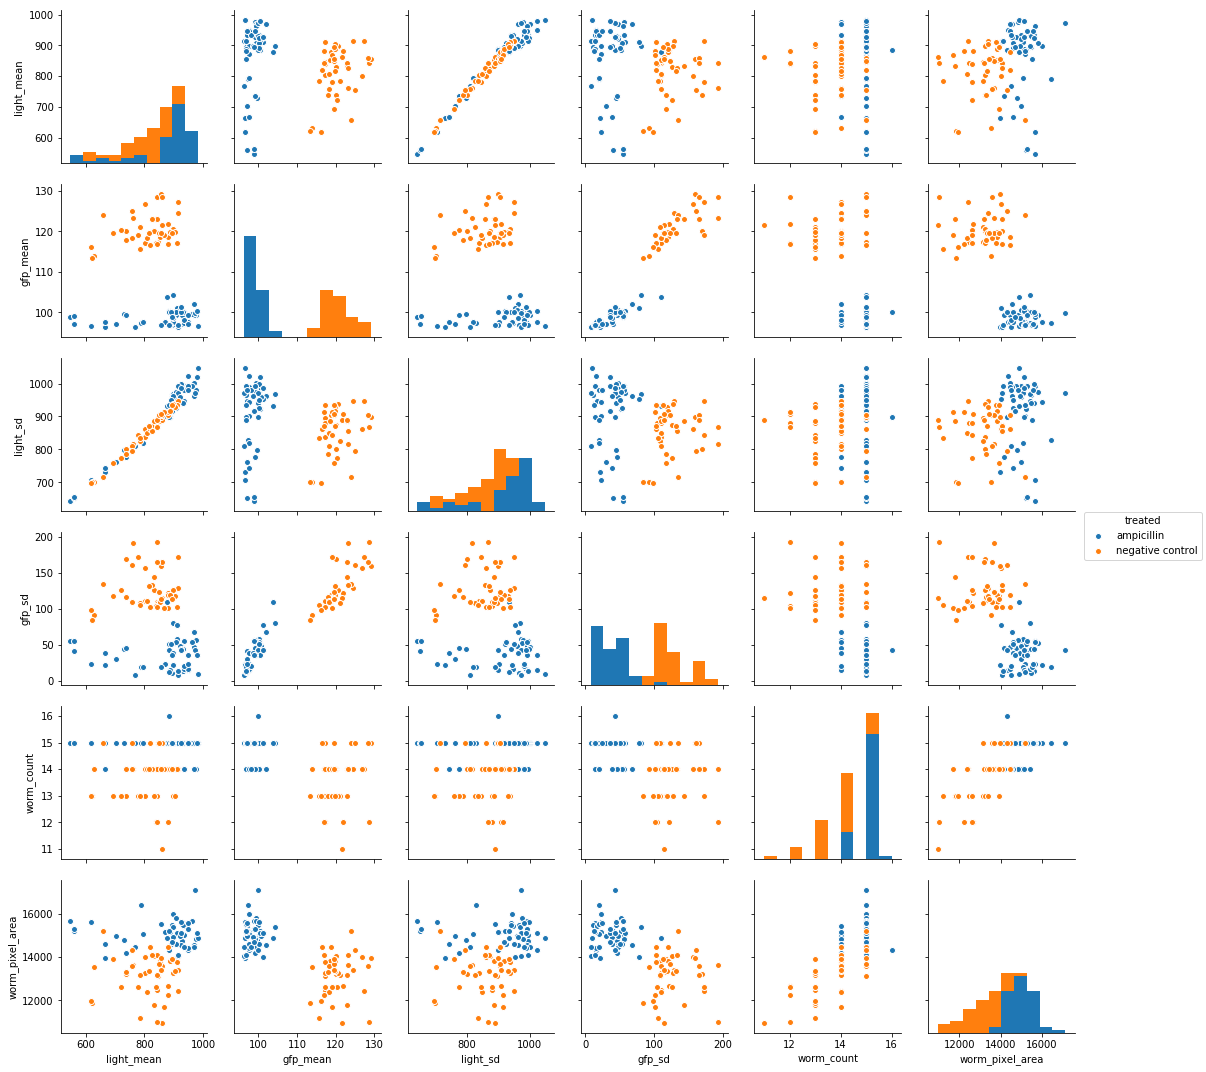

In [17]:
full_df=image_df.merge(worm_summary_df,on='plate_rc')
sns.pairplot(full_df.drop(['column'],1),hue='treated')

## Statistical evaluation of difference of the two distributions

In [18]:
from scipy.stats import ttest_ind, ttest_rel
# https://plot.ly/python/t-test/
# t_stats, p_vals = ttest_ind(full_df['gfp_mean'].values, full_df['worm_pixel_area'].values)

## http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas
treated = full_df[full_df['treated'] == 'ampicillin'].select_dtypes(['number']).drop('column', axis=1)
# full_df[full_df['treated'] == 'ampicillin'].select_dtypes([np.number])

control = full_df[full_df['treated'] != 'ampicillin'].select_dtypes(['number']).drop('column', axis=1)
# full_df[full_df['treated'] != 'ampicillin'].select_dtypes([np.number])

In [19]:
# probably need to normalize the data first?
def normalise(df):
    dfNorm = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return dfNorm

treatNorm = normalise(treated)
contNorm  = normalise(control)

If p-val > 0.01 (for example), we cannot reject the null hypothesis of identical distriibutions
-> if p-val < 0.01 - samples come from different distributions

In [20]:
t_stats, p_val = ttest_ind(treatNorm.values, #['gfp_mean']
                           contNorm.values) #['worm_pixel_area']

print("The t-statistic is {} and the p-value is {} ".format(t_stats, p_val))

The t-statistic is [ 1.38303849 -2.67136443  0.52419927 -2.14320114 -5.18712439 -4.17064148] and the p-value is [1.69895070e-01 8.88912457e-03 6.01360878e-01 3.46514798e-02
 1.20519569e-06 6.71239240e-05] 


### What to do next?
- one could try to predict treated = true / false based on contents of numerical columns
    - but this is trivial to implement (sklearn)

### We can leverage some pandas' methods to look at descriptive statistics 

# Use Keras and apply CNN 